In [1]:
# Download SVHN dataset (Format 2: Cropped Digits)from http://ufldl.stanford.edu/housenumbers/
# SVHN dataset is in matlab format, so we will use scipy to manipulate them into hdf5

In [2]:
import scipy.io
import random
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
%matplotlib inline

In [3]:
# Put dataset path here
svhnDatasetPath = '/home/thananop/cvt/svhn/'

In [4]:
trainingData = scipy.io.loadmat(svhnDatasetPath + 'train_32x32.mat', variable_names='X').get('X')
trainingLabels = scipy.io.loadmat(svhnDatasetPath + 'train_32x32.mat', variable_names='y').get('y')
testData = scipy.io.loadmat(svhnDatasetPath + 'test_32x32.mat', variable_names='X').get('X')
testLabels = scipy.io.loadmat(svhnDatasetPath + 'test_32x32.mat', variable_names='y').get('y')
extraData = scipy.io.loadmat(svhnDatasetPath + 'extra_32x32.mat', variable_names='X').get('X')
extraLabels = scipy.io.loadmat(svhnDatasetPath + 'extra_32x32.mat', variable_names='y').get('y')

print('Training Data Dimension : ',trainingData.shape, trainingLabels.shape)
print('Test Data Dimension : ',testData.shape, testLabels.shape)
print('Extra Data Dimension: ',extraData.shape, extraLabels.shape)

Training Data Dimension :  (32, 32, 3, 73257) (73257, 1)
Test Data Dimension :  (32, 32, 3, 26032) (26032, 1)
Extra Data Dimension:  (32, 32, 3, 531131) (531131, 1)


In [5]:
# SVHN dataset defines that digit '1' has label 1, '9' has label 9 and '0' has label 10 
# For the sake of simplicity, we will change class label of digit '0' to 0
trainingLabels[trainingLabels == 10] = 0
testLabels[testLabels == 10] = 0
extraLabels[extraLabels == 10] = 0

In [6]:
# Data shuffling (randomly pull 300,000 images from extra set)
nExtraImage = 300000
totalLabels = 10
trainIdx = []
extraIdx = []
for currentClass in np.arange(totalLabels):
    trainIdx.extend(np.where(trainingLabels[:,0] == (currentClass))[0][:].tolist())
    extraIdx.extend(np.where(extraLabels[:,0] == (currentClass))[0][:].tolist())
random.seed()
random.shuffle(trainIdx)
random.shuffle(extraIdx)

trainingData_t = np.concatenate((extraData[:,:,:,extraIdx[0:nExtraImage]], trainingData[:,:,:,trainIdx]), axis=3).transpose((3,0,1,2))
trainingLabels_t = np.concatenate((extraLabels[extraIdx[0:nExtraImage],:], trainingLabels[trainIdx,:]), axis=0)[:,0]
testData_t = testData.transpose(3,0,1,2)
testLabels_t = testLabels[:,0]
print('Training Data Dimension : ',trainingData_t.shape, trainingLabels_t.shape)
print('Test Data Dimension : ',testData_t.shape, testLabels_t.shape)

Training Data Dimension :  (373257, 32, 32, 3) (373257,)
Test Data Dimension :  (26032, 32, 32, 3) (26032,)


In [7]:
# Clean up loaded dataset (gc)
del trainingData,trainingLabels,testData,testLabels,extraData,extraLabels

In [8]:
def im2gray(image):
    '''Normalize images'''
    image = image.astype(float)
    imageGray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return imageGray

trainingData_t = im2gray(trainingData_t)[:,:,:,0]
testData_t = im2gray(testData_t)[:,:,:,0]

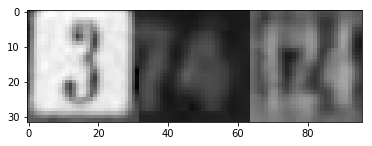

Class Label: 3 4 2


In [9]:
# Show Sample Data
randomIdx = random.sample(range(trainingData_t.shape[0]), 3)
randomImage = trainingData_t[randomIdx,:,:].transpose(1,2,0)
concatRandomImage = np.concatenate((randomImage[:,:,0],randomImage[:,:,1],randomImage[:,:,2]),axis=1)
plt.figure()
plt.imshow(concatRandomImage[:,:],cmap='gray')
plt.show()
print('Class Label:',trainingLabels_t[randomIdx[0]],trainingLabels_t[randomIdx[1]],trainingLabels_t[randomIdx[2]])

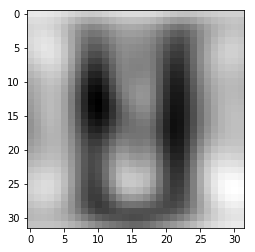

In [10]:
# Extract training data mean
trainingDataMean = trainingData_t.mean(axis=(0),dtype=np.float32)
plt.figure()
plt.imshow(trainingDataMean,cmap='gray')
plt.show()

In [11]:
# Dataset Mean Normalization 
trainingData_t -= trainingDataMean
testData_t -= trainingDataMean
print('Training Data Size : ',trainingData_t.nbytes,' bytes')

Training Data Size :  3057721344  bytes


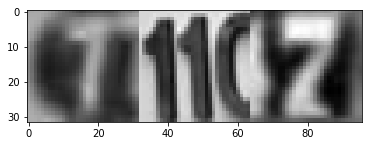

Class Label: 7 1 7


In [12]:
# Show Sample Normalized
randomIdx = random.sample(range(trainingData_t.shape[0]), 3)
randomImage = trainingData_t[randomIdx,:,:].transpose(1,2,0)
concatRandomImage = np.concatenate((randomImage[:,:,0],randomImage[:,:,1],randomImage[:,:,2]),axis=1)
plt.figure()
plt.imshow(concatRandomImage[:,:],cmap='gray')
plt.show()
print('Class Label:',trainingLabels_t[randomIdx[0]],trainingLabels_t[randomIdx[1]],trainingLabels_t[randomIdx[2]])

In [13]:
with h5py.File('svhnData.h5', 'w') as hf:
    hf.create_dataset("trainingData", data=trainingData_t)
    hf.create_dataset("trainingLabels", data=trainingLabels_t)
    hf.create_dataset("testData", data=testData_t)
    hf.create_dataset("testLabels", data=testLabels_t)

print('Compressed hdf5 size:', os.stat('svhnData.h5').st_size)

Compressed hdf5 size: 3271378969
